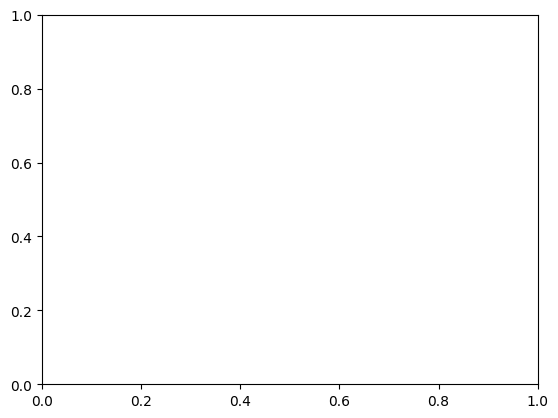

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

In [201]:
EPISODES = 10_000
MAX_STEPS = 200
COLUMNS = 10
ROWS = 10
ACTION_MAPPINGS = {
    0: (-1, 0),  # Move up
    1: (1, 0),   # Move down
    2: (0, -1),  # Move left
    3: (0, 1)    # Move right
}


In [202]:
class GridEnv(gym.Env):
    def __init__(self):
        super(GridEnv, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.obstacle_position = [np.random.randint(ROWS), np.random.randint(COLUMNS)]
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        self.total_rewards_collected = 0
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        self.reward_map[self.obstacle_position[0], self.obstacle_position[1]] = -100
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
            
    def reset_reward_map(self):
        self.initialize_reward_map()
        self.reward_map[0,0] = -1  # Mark the starting position

    def step(self, action):
        # Initialize done as False
        done = False
        reward = 0.
        
        
        # Update state based on action with x, y format
        delta = ACTION_MAPPINGS.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])
        # if np.array_equal(new_state, prev_state):
        #     reward = -10

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            reward = -100
            done = True
        else:
            # Update the current state and the previous state
            self.state = new_state                  # Update the current state to new state

            self.step_counter += 1
            reward += self.calculate_reward()
            done = self.is_done()

            y = self.state[0]
            x = self.state[1]
            self.reward_map[y, x] = -1

        return self.state, reward, done, {}
            
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        return self.reward_map[self.state[0], self.state[1]]        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = MAX_STEPS  # Example step limit
        count_minus_one = np.sum(self.reward_map == -1)
        count_minus_hundred = np.sum(self.reward_map == -100)
        return count_minus_one == (self.reward_map.size - 1) and count_minus_hundred == 1 or self.step_counter >= max_steps    
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [203]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, prev_state, state, neg_reward):

        def get_new_state(action):
            delta = ACTION_MAPPINGS.get(action, (0, 0))
            return np.array([state[0] + delta[0], state[1] + delta[1]])

        def is_valid_action(action):
            new_state = get_new_state(action)
            return not np.array_equal(new_state, prev_state)
        
        def find_second_best_action(q_values):
            # Copy to avoid modifying the original array
            temp_q_values = np.copy(q_values)

            # Find the index of the best action
            best_action = np.argmax(temp_q_values)

            # Mask the best action by setting its value to negative infinity
            temp_q_values[best_action] = -np.inf

            # Find the second best action
            second_best_action = np.argmax(temp_q_values)

            return second_best_action

        action = None
        state_index = (state[0], state[1])
        if neg_reward > 3:
            # Implement logic to find the nearest positive reward
            action = self.find_nearest_positive_reward_action(state)
        elif np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit: best known action

        if not is_valid_action(action):
            action = find_second_best_action(self.q_table[state_index])



        # Additional check or fallback strategy if needed
        if not is_valid_action(action):
            # Implement fallback strategy, e.g., select a random action
            action = self.env.action_space.sample()

        return action
    
    def find_nearest_positive_reward_action(self, state):
        min_distance = float('inf')
        best_action = None

        # Search the grid for the nearest positive reward
        for y in range(ROWS):
            for x in range(COLUMNS):
                if self.env.reward_map[y, x] > 0:  # Check for positive reward
                    distance = abs(state[0] - y) + abs(state[1] - x)
                    if distance < min_distance:
                        min_distance = distance
                        best_action = self.determine_action_to_reward(state, (y, x))

        return best_action

    def determine_action_to_reward(self, current_state, reward_state):
        dy = reward_state[0] - current_state[0]
        dx = reward_state[1] - current_state[1]

        if abs(dy) > abs(dx):
            return 1 if dy > 0 else 0  # Move down (1) or up (0) based on the y-difference
        else:
            return 3 if dx > 0 else 2  # Move right (3) or left (2) based on the x-difference
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error



In [204]:
def train_agent(env, agent, episodes):
    best_total_reward = -float('inf')
    best_path = []
    best_wheat_collected = []  # List to keep track of wheat collection

    for episode in range(episodes):
        state = env.reset()
        prev_state = None
        current_path = [state]
        wheat_collected = []  # List for the current episode
        done = False
        total_reward = 0
        neg_reward = 0

        while not done:
            action = agent.choose_action(prev_state, state, neg_reward)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
                
            total_reward += reward
            prev_state = state
            state = next_state
            current_path.append(state)

            if reward == 1:  # Check if wheat is collected
                wheat_collected.append(True)
            else:
                wheat_collected.append(False)

            if reward < 0:
                neg_reward += 1
            else: 
                neg_reward = 0

        if total_reward > best_total_reward:
            best_total_reward = total_reward
            best_path = current_path
            best_wheat_collected = wheat_collected  # Update the best wheat collection list

        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}")

    return best_path, best_wheat_collected


In [205]:
# Train the agent
env = GridEnv()
agent = QLearningAgent(env)
best_path, wheat_collected = train_agent(env, agent, episodes=EPISODES)


Episode 0: Total Reward: -100
Episode 10: Total Reward: -90.0
Episode 20: Total Reward: -85.0
Episode 30: Total Reward: -98.0
Episode 40: Total Reward: -97.0
Episode 50: Total Reward: -171.0
Episode 60: Total Reward: -93.0
Episode 70: Total Reward: -86.0
Episode 80: Total Reward: -162.0
Episode 90: Total Reward: -172.0
Episode 100: Total Reward: -85.0
Episode 110: Total Reward: -87.0
Episode 120: Total Reward: -100
Episode 130: Total Reward: -86.0
Episode 140: Total Reward: -152.0
Episode 150: Total Reward: -68.0
Episode 160: Total Reward: -90.0
Episode 170: Total Reward: -91.0
Episode 180: Total Reward: -63.0
Episode 190: Total Reward: -69.0
Episode 200: Total Reward: -99.0
Episode 210: Total Reward: -63.0
Episode 220: Total Reward: 2.0
Episode 230: Total Reward: -81.0
Episode 240: Total Reward: -63.0
Episode 250: Total Reward: -75.0
Episode 260: Total Reward: -85.0
Episode 270: Total Reward: -100
Episode 280: Total Reward: -103.0
Episode 290: Total Reward: -93.0
Episode 300: Total Re

In [206]:
def animation_plot(frame, state, env, ax, wheat_count):
    # Update the reward map to reflect the agent's movement
    env.reward_map[state[0], state[1]] = -1

    ax.clear()
    ax.imshow(env.reward_map, cmap=cmap, norm=norm, alpha=0.8)  # Use the custom colormap
    ax.scatter(state[1], state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

    # Display the current position at the top of the plot
    position_text = f"Current Position: x={state[1]}, y={state[0]}"
    ax.text(0.5, 1.05, position_text, transform=ax.transAxes, ha='center', va='bottom')

    # Display the total wheat collected
    wheat_text = f"Wheat Collected: {wheat_count}"
    ax.text(0.5, 1.1, wheat_text, transform=ax.transAxes, ha='center', va='bottom', color='black')

    # Display the current frame at the bottom of the plot
    frame_text = f"Step: {frame}"
    ax.text(0.5, 0.01, frame_text, transform=ax.transAxes, ha='center', va='bottom', color='black')    



def update(frame, best_path, wheat_collected, env, ax):
    if frame < len(best_path) and frame < len(wheat_collected):
        state = best_path[frame]
        wheat_count = sum(wheat_collected[:frame + 1])  # Calculate total wheat collected up to this frame
        animation_plot(frame, state, env, ax, wheat_count)
    else:
        update.done = True  # Stop the animation when the end of the best path is reached

colors = ['black', 'green', 'white', 'yellow']  # Replace with actual colors
cmap = mcolors.ListedColormap(colors)

# Define the boundaries for these values
# The values are chosen to ensure that -100, -1, and 1 fall into separate bins
bounds = [-200, -1, 1, 200]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


In [207]:
# Reset the environment and reward map to initial state
env.reset()
env.reset_reward_map()

# Create the animation using the best path
animation = FuncAnimation(fig, lambda frame: update(frame, best_path, wheat_collected, env, ax),
                          frames=len(best_path), interval=100)# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


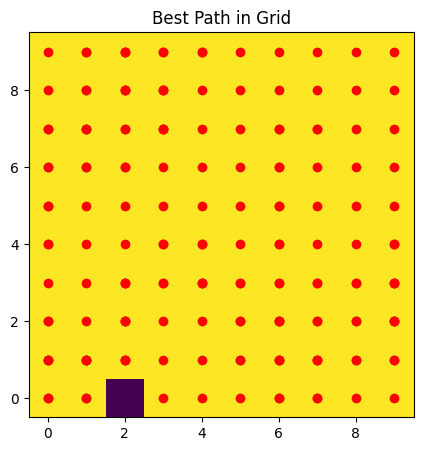

[array([0, 0]), array([0, 1]), array([1, 1]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([8, 0]), array([9, 0]), array([9, 1]), array([8, 1]), array([7, 1]), array([7, 2]), array([6, 2]), array([6, 1]), array([5, 1]), array([4, 1]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([7, 1]), array([7, 2]), array([7, 3]), array([8, 3]), array([8, 2]), array([9, 2]), array([9, 3]), array([9, 4]), array([9, 5]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([7, 9]), array([6, 9]), array([5, 9]), array([4, 9]), array([3, 9]), array([2, 9]), array([1, 9]), array([0, 9]), array([0, 8]), array([1, 8]), array([1, 7]), array([0, 7]), array([0, 6]), array([1, 6]), array([1, 5]), array([0, 5]), array([0, 4]), array([0, 3]), array([1, 3]), array([1, 4]), array([2, 4]), array([2, 3]), array([3, 3]), array([3, 2]), array([2, 2]), array([1, 2]), array([1, 1]), array([1, 0]), array([2,

In [208]:
def plot_best_path(env, best_path):
    plt.figure(figsize=(5, 5))
    plt.imshow(env.reward_map, cmap='viridis', origin='lower')

    # Plot the path
    for state in best_path:
        plt.scatter(state[1], state[0], c='red', marker='o')

    plt.title("Best Path in Grid")
    plt.show()
plot_best_path(env, best_path)
print(best_path)

In [209]:
def transform_path(original_path, iteration):
    transformed_path = []
    ROWS = 10  # Assuming the number of rows is constant at 10

    for x, y in original_path:
        if iteration % 2 == 1:
            # For odd iterations, increase x and increment y
            new_x = x
            new_y = y + (iteration - 1)
        else:
            # For even iterations, decrease x and increment y
            new_x = ROWS - 1 - x
            new_y = y + (iteration - 1)
        
        transformed_path.append(np.array([new_x, new_y]))

    # Add the last point of the iteration
    if iteration % 2 == 1:
        transformed_path.append(np.array([ROWS - 1, transformed_path[-1][1] + 1]))
    else:
        transformed_path.append(np.array([0, transformed_path[-1][1] + 1]))

    return transformed_path

for iteration in range(1, 4):
    print(f"Iteration {iteration}: {transform_path(best_path, iteration)}")

Iteration 1: [array([0, 0]), array([0, 1]), array([1, 1]), array([1, 0]), array([2, 0]), array([3, 0]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([8, 0]), array([9, 0]), array([9, 1]), array([8, 1]), array([7, 1]), array([7, 2]), array([6, 2]), array([6, 1]), array([5, 1]), array([4, 1]), array([4, 0]), array([5, 0]), array([6, 0]), array([7, 0]), array([7, 1]), array([7, 2]), array([7, 3]), array([8, 3]), array([8, 2]), array([9, 2]), array([9, 3]), array([9, 4]), array([9, 5]), array([9, 6]), array([9, 7]), array([9, 8]), array([9, 9]), array([8, 9]), array([7, 9]), array([6, 9]), array([5, 9]), array([4, 9]), array([3, 9]), array([2, 9]), array([1, 9]), array([0, 9]), array([0, 8]), array([1, 8]), array([1, 7]), array([0, 7]), array([0, 6]), array([1, 6]), array([1, 5]), array([0, 5]), array([0, 4]), array([0, 3]), array([1, 3]), array([1, 4]), array([2, 4]), array([2, 3]), array([3, 3]), array([3, 2]), array([2, 2]), array([1, 2]), array([1, 1]), array([1, 0

In [210]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)